In [3]:
# make the code as Python 3 compatible as possible
from __future__ import print_function, division
import pypsa
import pandas as pd
import numpy as np
import geopy.distance
import glob
import numpy as np
import datetime


# Printing
from pprint import *

# Plotting
import matplotlib
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import cartopy.crs as ccrs

# Display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 20)



## Preprocessing: Calculate line distances based on lat/long coordinates
#df = pd.read_csv(r"C:\Users\Willem\pypsa-eur\data\minimal_example/buses.csv", sep = ";", encoding='latin-1')
#df = df.rename(columns = {df.columns[0] : 'name'})
#display(df)

#for index, row in df.iterrows():
#    coords1 = (row["x"],row["y"])
#    for index1, row1 in df.iterrows():
#        coords2 = (row1["x"],row1["y"])
#        dict_dist.update({str(row["name"]) + " and " + str(row1["name"]) : geopy.distance.distance(coords1, coords2).m})
#pprint(dict_dist)


In [5]:
#### Extract typical generation power capacities from entsoe (has to be imported in complicated way)

df_pp_entsoe = pd.read_csv(r"C:\Users\Willem\pypsa-eur\data\entsoegridkit/generators.csv", sep = ",", encoding='latin-1', header=None, skiprows= 1, usecols=[2,3,4,5,6,7])
df_pp_entsoe = df_pp_entsoe.iloc[1:].dropna()
df_pp_entsoe.columns = ["technology","capacity","TSO","oid","name","country"]
df_pp_entsoe = df_pp_entsoe.drop(df_pp_entsoe[df_pp_entsoe["technology"] == "Other or not listed"].index).reset_index(drop=True)

#only keep entries from germany
df_pp_entsoe["country"] = df_pp_entsoe["country"].str.split(r"=>", expand=False).str[-1].str.strip(to_strip = '"')
df_pp_entsoe = df_pp_entsoe.drop(df_pp_entsoe[df_pp_entsoe["country"] != 'DE'].index).reset_index(drop=True)
df_pp_entsoe["capacity"] = pd.to_numeric(df_pp_entsoe["capacity"])

# calculate average generation capacity by generation technology
df_group_entsoe = df_pp_entsoe.groupby(by = ["technology"]).mean().drop(["Fossil fuel","Hydro pure pump storage"])
df_group_entsoe = df_group_entsoe.rename(index = {'Hydro run of river & pondage':'Hydro mixed pump storage'})
df_group_entsoe = df_group_entsoe.groupby(by = df_group_entsoe.index, sort=False).sum() 
df_group_entsoe = df_group_entsoe.rename(index = {"Brown coal/Lignite": "Lignite", 
                                                  "Fossil gas": "Gas", 
                                                  "Fossil oil": "Oil",
                                                  "Hydro mixed pump storage": "Hydro",
                                                  "Wind farm": "Wind"
                                                  },
                                         columns = {"capacity": "capacity_mw"})
display(df_group_entsoe)

#### Extract typical generation power capacities from GPP dataset 
df_pp_gpp = pd.read_csv(r"C:\Users\Willem\pypsa-eur\data\Redispatch/global_power_plant_database.csv")
df_pp_gpp = df_pp_gpp[["country_long","name","capacity_mw","primary_fuel"]].copy()
df_pp_gpp = df_pp_gpp.drop(df_pp_gpp[df_pp_gpp["country_long"] != "Germany"].index).reset_index(drop = True)

# Get average power by energy fuel
df_group_gpp = pd.DataFrame(df_pp_gpp.groupby(by = ["primary_fuel"])["capacity_mw"].mean())
display(df_group_gpp)

#### Average both datasets together
df_group = pd.concat([df_group_gpp, df_group_entsoe])
df_group = pd.DataFrame(df_group.groupby(by = df_group.index)["capacity_mw"].mean())
display(df_group)

,capacity_mw
technology,
Lignite,1277.848485
Gas,790.500000
Oil,205.000000
Hard coal,595.937500
Hydro,208.700000
Nuclear,1349.125000
Wind,153.437500


,capacity_mw
primary_fuel,
Biomass,31.232075
Coal,497.634375
Gas,135.723611
Hydro,89.143750
Nuclear,1595.857143
Oil,118.800000
Other,68.809091
Solar,9.541576
Waste,24.072727


,capacity_mw
Biomass,31.232075
Coal,497.634375
Gas,463.111806
Hard coal,595.937500
Hydro,148.921875
Lignite,1277.848485
Nuclear,1472.491071
Oil,161.900000
Other,68.809091
Solar,9.541576


In [6]:
#### PREPARATION OF DATA FOR IMPORTING TO NETWORK 

# bring excel sheets to correct separator format
path = r"C:\Users\Willem\pypsa-eur\data\minimal_example\*.csv"
target_path = r"C:\Users\Willem\pypsa-eur\data\minimal_example\input"
csv_folder_name = r"C:\Users\Willem\pypsa-eur\data\minimal_example\input_lopf"


for fname in glob.glob(path):
    print(fname)
    df_input = pd.read_csv(fname, sep = ";", encoding='latin-1')
    ftarget = fname.split("\\")[-1]
    print(type(ftarget))
    df_input.to_csv(path_or_buf = target_path + "\\" + ftarget, sep= ",")
    

C:\Users\Willem\pypsa-eur\data\minimal_example\buses.csv
<class 'str'>
C:\Users\Willem\pypsa-eur\data\minimal_example\carriers.csv
<class 'str'>
C:\Users\Willem\pypsa-eur\data\minimal_example\generators.csv
<class 'str'>
C:\Users\Willem\pypsa-eur\data\minimal_example\lines.csv
<class 'str'>
C:\Users\Willem\pypsa-eur\data\minimal_example\loads.csv
<class 'str'>


In [50]:
#### DEFINE HELPER FUNCTIONS FOR BUILDING NETWORK

# Define helper functions for lopf

def my_f(network,snapshots):
    print(snapshots)
    
def print_lopf_insights(network):
    # generator power
    print(" \nGenerator active power per snapshot:")
    print(network.generators_t.p)

    # network line flows
    print(" \nLine active power per snapshot:")
    print(network.lines_t.p0)
    
    # relative line loading
    print(" \nRelative line loading per snapshot:")
    print(abs(network.lines_t.p0)/network.lines.s_nom)

    #In linear approximation, all voltage magnitudes are nominal, i.e. 1 per unit
    print(" \nVoltage magnitude at nodes:")
    print(network.buses_t.v_mag_pu)

    #At bus 2 the price is set above any marginal generation costs in the model, because to dispatch to
    #it from expensive generator 0, also some dispatch from cheap generator 1 has to be substituted from generator0
    #to avoid overloading line 1.
    print(" \nMarginal prices at nodes:")
    print(network.buses_t.marginal_price)
    
# Define builder functions
    
def create_snapshots(T,w,network):
    '''
    Creates snapshots for T hours with weighting w (each snapshot representing w hours)
    '''
    network.set_snapshots(pd.to_datetime([datetime.datetime(2019,1,1) + datetime.timedelta(hours=i) for i in range(T)]))
    network.snapshot_weightings = pd.Series(w,index=network.snapshots)
    
    
def add_energy_carriers():
    network.add("Carrier","gas",co2_emissions=0.24)
    network.add("Carrier","wind",co2_emissions=0.0)
    network.add("Carrier","battery",co2_emissions=0.0)
    network.add("Carrier","hydro",co2_emissions=0.0)
    network.add("Carrier","lignite",co2_emissions=0.)
    network.add("Carrier","hard coal",co2_emissions=0.0)
    network.add("Carrier","oil",co2_emissions=0.0)
    network.add("Carrier","nuclear",co2_emissions=0.0)
    network.add("Carrier","solar",co2_emissions=0.0)

    
def add_buses(csv_folder):
    '''
    Adds the predefined buses to the model
    '''
    buses_imp = pd.read_csv(csv_folder + '/buses.csv')
    buses_imp.drop(columns = buses_imp.columns[0], inplace = True)
    buses = buses_imp.copy().rename(columns = {buses_imp.columns[0] : 'attribute'})
    buses.set_index(["attribute"], inplace = True)
    network.import_components_from_dataframe(buses, "Bus")
    
    
def add_lines(csv_folder):
    '''
    Adds the predefined lines to the model.
    Make the nw -> sw line capacity NON-EXTENDABLE -> constrained line
    '''    
    lines = (pd.read_csv(csv_folder + '/lines.csv'))
    lines.drop(columns = lines.columns[0], inplace = True)
    lines = lines.copy().rename(columns = {lines.columns[0] : 'attribute'})
    lines.set_index(["attribute"], inplace = True)
    network.import_components_from_dataframe(lines, "Line")
    
    # constrained line (non extendable s_nom)
    network.lines.at["line_n_s_1","s_nom"] = 1500
    network.lines.at["line_n_s_1","s_nom_extendable"] = False
    
    
def add_generators(csv_folder):
    '''
    Adds predefined conventional generators.
    Adds renewable generators.
    '''
    generators = pd.read_csv(csv_folder + '/generators.csv').iloc[:, 0:6]
    generators.drop(columns = generators.columns[0], inplace = True)
    generators = generators.copy().rename(columns = {generators.columns[0] : 'attribute'})
    generators.set_index(["attribute"], inplace = True)
    network.import_components_from_dataframe(generators, "Generator")
    # Wind generator
    network.add("Generator", "Wind_1", 
                carrier = "wind", 
                bus = "bus_1_nw",
                p_nom = 170,
                eficiency = 0.78,  
                marginal_cost = 0 + 0.01, # non zero marginal cost to ensure unique optimization result
                capital_cost = 0,
                p_nom_extendable = True,
                p_nom_min = 100,
                p_nom_max = 300,
               )
    # PV generator
    network.add("Generator", "PV_1", 
                carrier = "solar", 
                bus = "bus_3_sw",
                p_nom = 10,
                efficiency = 0.99,
                marginal_cost = 0 + 0.01, # non zero marginal cost to ensure unique optimization result
                capital_cost = 0,
                p_nom_extendable = True,
                p_nom_max = 30,
                p_nom_min=0
               )
    
    
def add_loads(): 
    '''
    Adds static loads to the network
    Removes previously added loads from network
    '''
    network.mremove("Load", [name for name in network.loads.index.tolist()])
    load_dict = {"load_1_ne": ("bus_2_ne", 500), "load_2_sw": ("bus_3_sw", 2000), "load_3_se": ("bus_4_se", 1000)}
    for load in load_dict:
        network.add("Load", 
                    name = load, 
                    bus = load_dict[load][0],
                    p_set = load_dict[load][1],
                    sign = -1
                   )

              
def add_time_series():
    '''
    Creates time series for load, wind generation and solar generation by scaling the scalar nominal power 
    with relative generation time series for germany (relative to mean generation of each technology):
    - time series for loads
    - time series for wind generation
    - time series for pv generation
    '''
    # Import load and generation data for germany
    df_ger = pd.read_csv(r"C:\Users\Willem\pypsa-eur\data\Redispatch\opsd-time_series-2020-10-06/time_series_60min_singleindex.csv")
    cols_ger = list(df_ger.loc[:,"DE_load_actual_entsoe_transparency":'DE_transnetbw_wind_onshore_generation_actual'])
    cols_ger.append("cet_cest_timestamp")
    cols_ger = [cols_ger[-1]] + cols_ger[:-1]
    df_ger = df_ger.loc[:,cols_ger]
    
    # change index to datetime object
    df_ger[["Date","Time"]] = df_ger["cet_cest_timestamp"].str.split(pat = "T", expand = True)
    df_ger[["Time","xxxx"]] = df_ger["Time"].str.split(pat = "+", expand = True)
    df_ger = df_ger.drop(["xxxx","cet_cest_timestamp"],axis = 1)
    df_ger["name"] = pd.to_datetime(df_ger['Date'] + ' ' + df_ger['Time'])
    df_ger = df_ger.drop(["Date","Time"], axis = 1).set_index("name", drop = True)
    df_ger = df_ger.loc["2019-01-01 00:00:00":"2019-12-31 23:00:00", :]
    #df_ger = df_ger[~df_ger.index.duplicated(keep='first')]
    df_ger.reset_index(inplace = True, drop = True)
    display(df_ger)
    
    # Generate relative columns to get the load profile
    s_loads = df_ger["DE_load_actual_entsoe_transparency"].divide(df_ger["DE_load_actual_entsoe_transparency"].mean())
    s_wind  = df_ger["DE_wind_generation_actual"].divide(df_ger["DE_wind_generation_actual"].mean())
    s_solar = df_ger["DE_solar_generation_actual"].divide(df_ger["DE_solar_generation_actual"].mean())
    
    #### Time series to dicts
    # Create empty dicts
    dict_loads = {}
    dict_wind = {}
    dict_solar = {}
    # load time series
    for load in network.loads.index:
        dict_loads[load] = s_loads * network.loads.p_set[load] 
    # wind time series
    wind_generators = network.generators[network.generators.carrier == "wind"]
    for wind in wind_generators.index:
        dict_wind[wind] = s_wind
    # Solar time series
    solar_generators = network.generators[network.generators.carrier == "solar"]
    for solar in solar_generators.index:
        dict_solar[solar] = s_solar
        
    #### Dicts to dataframes
    df_loads = pd.DataFrame.from_dict(dict_loads, orient = "columns")
    df_wind = pd.DataFrame.from_dict(dict_wind, orient = "columns")
    df_solar = pd.DataFrame.from_dict(dict_solar, orient = "columns")
    # load time series
    network.loads_t.p_set = pd.DataFrame(index = network.snapshots, 
                                         columns = network.loads.index,
                                         data = df_loads.to_numpy(copy = True))
    # Wind time series
    network.generators_t.p_max_pu = network.generators_t.p_max_pu.reindex(columns=wind_generators.index)
    network.generators_t.p_max_pu.loc[:,wind_generators.index] = pd.DataFrame(index = network.snapshots,
                                                                              columns = wind_generators.index,
                                                                              data = df_wind.to_numpy(copy= True))
    # Solar time series
    network.generators_t.p_max_pu.loc[:,solar_generators.index] = pd.DataFrame(index = network.snapshots,
                                                                              columns = solar_generators.index,
                                                                              data = df_solar.to_numpy(copy= True))
    
def build_base_network(T, w, network, csv_folder, csv_folder_lopf):
    '''
    Uses predefined component building functions for building initial example grid without hydro and battery storage
    '''
    create_snapshots(T, w, network)
    add_energy_carriers()
    add_buses(csv_folder)
    add_lines(csv_folder)
    add_generators(csv_folder)
    add_loads()
    display(network.generators[network.generators.carrier == "wind"])
    add_time_series()
    network.export_to_csv_folder(csv_folder_lopf)
    network.name = "Base network"

        
def add_storage_units(network):
    '''
    Adds all non-battery storage units to the base network
    Removes previously added storage units from the network
    '''
    network.mremove("StorageUnit", [name for name in network.storage_units.index.tolist()])
    network.add("StorageUnit", name = "PHES_1",
                bus = "bus_4_se",
                control = "PQ",
                p_nom = 150,
                marginal_cost = 20,
                capital_cost = 0,
                p_nom_extendable = True,
                p_max_pu = 1,
                p_min_pu = -1,
                efficiency_store = 0.86,
                efficiency_dispatch = 0.89,
                state_of_charge_initial = 0.0,
                max_hours = 1000,
                standing_loss = 0.01,
                inflow = 0.02 
               )
    
def add_BESS(network):
    '''
    Adds static battery storages (fixed capacity) to the base network
    Removes previously added batteries (links and stores) from the network
    
    A battery is added to the network by combining a link for discharge, and one for charge (representing inverter operations)
    and a store unit representing the battery capacity
    '''
    # Clean up all previously saved battery components
    network.mremove("Link", [name for name in network.links.index.tolist()])
    network.mremove("Store", [name for name in network.stores.index.tolist()])
    network.mremove("Bus", [name for name in network.buses.index.tolist() if "BESS" in name])
    
    bus_names = network.buses.index.tolist()
    for i in range(len(bus_names)):
        bus_name = bus_names[i]
        battery_bus = "{}_{}".format(bus_name,"BESS")
        # add additional bus solely for representation of battery at location of previous bus
        network.add("Bus",
                    name = battery_bus,
                    x = network.buses.loc[bus_name,"x"],
                    y = network.buses.loc[bus_name,"y"],
                    carrier = "battery")
        # discharge link
        network.add("Link",
                    name = "Battery_{}_dCH".format(i+1),
                    bus0 = battery_bus,
                    bus1 = bus_name,
                    capital_cost = 0,
                    p_nom = 150,
                    p_nom_extendable = True,
                    p_max_pu = 1,
                    p_min_pu = 0,
                    marginal_cost = 0,
                    efficiency = 0.96)
        # charge link
        network.add("Link",
                    name = "Battery_{}_CH".format(i+1),
                    bus0 = bus_name,
                    bus1 = battery_bus,
                    capital_cost = 0,
                    p_nom = 150,
                    p_nom_extendable = True,
                    p_max_pu = 1,
                    p_min_pu = 0,
                    marginal_cost = 0,
                    efficiency = 0.96)
        # add store
        network.add("Store", name = "BESS_{}".format(i),    
                    bus = battery_bus,
                    e_nom = 200,
                    e_nom_extendable = False,
                    e_min_pu = 0,
                    e_max_pu = 1,
                    e_initial = 0.5,
                    e_cyclic = True,
                    p_set = 100,
                    q_set = 0.05,
                    marginal_cost = 0,
                    capital_cost = 0,
                    standing_loss = 0)

#def add_BESS_extendable():
    
def clean_storages(network):
    """
    Clean up all previously saved battery components
    """
    network.mremove("StorageUnit", [name for name in network.storage_units.index.tolist()])
    network.mremove("Link", [name for name in network.links.index.tolist()])
    network.mremove("Store", [name for name in network.stores.index.tolist()])
    network.mremove("Bus", [name for name in network.buses.index.tolist() if "BESS" in name])



In [51]:
# build initial network
network = pypsa.Network()

# create network & add components from csv folder
csv_folder = r"C:\Users\Willem\pypsa-eur\data\minimal_example\input"
csv_folder_lopf = r"C:\Users\Willem\pypsa-eur\data\minimal_example\input_lopf"

# add network components
build_base_network(8760,1,network,csv_folder,csv_folder_lopf)

display(pd.DataFrame(network.snapshots))
display(network.carriers)
display(network.buses)
display(network.lines)
display(network.generators)
display(network.loads)
display(network.generators_t.p_set)
display(network.loads_t.p_set)

## plot networks
#print(type(network))
#network.plot(geomap = False)

,bus,carrier,p_nom,marginal_cost,control,type,p_nom_extendable,p_nom_min,p_nom_max,p_min_pu,p_max_pu,p_set,q_set,sign,capital_cost,efficiency,committable,start_up_cost,shut_down_cost,min_up_time,min_down_time,up_time_before,down_time_before,ramp_limit_up,ramp_limit_down,ramp_limit_start_up,ramp_limit_shut_down,p_nom_opt
Wind_1,bus_1_nw,wind,170.0,0.01,PQ,,True,100.0,300.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,False,0.0,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0.0


,DE_load_actual_entsoe_transparency,DE_load_forecast_entsoe_transparency,DE_solar_capacity,DE_solar_generation_actual,DE_solar_profile,DE_wind_capacity,DE_wind_generation_actual,DE_wind_profile,DE_wind_offshore_capacity,DE_wind_offshore_generation_actual,DE_wind_offshore_profile,DE_wind_onshore_capacity,DE_wind_onshore_generation_actual,DE_wind_onshore_profile,DE_50hertz_load_actual_entsoe_transparency,DE_50hertz_load_forecast_entsoe_transparency,DE_50hertz_solar_generation_actual,DE_50hertz_wind_generation_actual,DE_50hertz_wind_offshore_generation_actual,DE_50hertz_wind_onshore_generation_actual,DE_LU_load_actual_entsoe_transparency,DE_LU_load_forecast_entsoe_transparency,DE_LU_price_day_ahead,DE_LU_solar_generation_actual,DE_LU_wind_generation_actual,DE_LU_wind_offshore_generation_actual,DE_LU_wind_onshore_generation_actual,DE_amprion_load_actual_entsoe_transparency,DE_amprion_load_forecast_entsoe_transparency,DE_amprion_solar_generation_actual,DE_amprion_wind_onshore_generation_actual,DE_tennet_load_actual_entsoe_transparency,DE_tennet_load_forecast_entsoe_transparency,DE_tennet_solar_generation_actual,DE_tennet_wind_generation_actual,DE_tennet_wind_offshore_generation_actual,DE_tennet_wind_onshore_generation_actual,DE_transnetbw_load_actual_entsoe_transparency,DE_transnetbw_load_forecast_entsoe_transparency,DE_transnetbw_solar_generation_actual,DE_transnetbw_wind_onshore_generation_actual
0,42976.0,43213.0,47480.0,0.0,0.0,48974.0,23132.0,0.4723,5051.0,3136.0,0.6210,43923.0,19995.0,0.4552,8880.0,6504.0,0.0,8847.0,1020.0,7827.0,43490.0,43628.0,28.32,0.0,23132.0,3136.0,19995.0,15331.0,17560.0,0.0,2408.0,13724.0,13557.0,0.0,11783.0,2116.0,9667.0,5041.0,5593.0,0.0,94.0
1,41562.0,41275.0,47480.0,0.0,0.0,48974.0,24905.0,0.5085,5051.0,2868.0,0.5678,43923.0,22036.0,0.5017,8604.0,6161.0,0.0,9671.0,1015.0,8656.0,41902.0,41662.0,10.07,0.0,24905.0,2868.0,22036.0,14872.0,16896.0,0.0,2979.0,13222.0,12943.0,0.0,12150.0,1853.0,10297.0,4864.0,5275.0,0.0,105.0
2,40100.0,40188.0,47480.0,0.0,0.0,48974.0,25208.0,0.5147,5051.0,2460.0,0.4870,43923.0,22748.0,0.5179,8205.0,6035.0,0.0,9966.0,660.0,9307.0,40291.0,40553.0,-4.08,0.0,25208.0,2460.0,22748.0,14823.0,16632.0,0.0,3123.0,12464.0,12611.0,0.0,12015.0,1800.0,10214.0,4607.0,4910.0,0.0,103.0
3,38883.0,39909.0,47480.0,0.0,0.0,48974.0,26568.0,0.5425,5051.0,2698.0,0.5341,43923.0,23870.0,0.5435,7609.0,6057.0,0.0,10316.0,615.0,9701.0,39274.0,40261.0,-9.91,0.0,26568.0,2698.0,23870.0,14640.0,16552.0,0.0,3524.0,12108.0,12521.0,0.0,12578.0,2082.0,10496.0,4526.0,4778.0,0.0,149.0
4,38806.0,40258.0,47480.0,0.0,0.0,48974.0,28500.0,0.5819,5051.0,2578.0,0.5105,43923.0,25922.0,0.5902,7564.0,6120.0,0.0,10910.0,494.0,10416.0,39191.0,40603.0,-7.41,0.0,28500.0,2578.0,25922.0,14678.0,16667.0,0.0,4096.0,11963.0,12677.0,0.0,13298.0,2084.0,11214.0,4601.0,4794.0,0.0,196.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,50151.0,56841.0,NaN,0.0,NaN,NaN,9702.0,NaN,NaN,1251.0,NaN,NaN,8451.0,NaN,10406.0,12344.0,0.0,6138.0,768.0,5370.0,50612.0,57642.0,46.00,0.0,9702.0,1251.0,8451.0,17977.0,22350.0,0.0,1013.0,15763.0,16467.0,0.0,2473.0,483.0,1990.0,6005.0,5680.0,0.0,79.0
8756,47493.0,54131.0,NaN,0.0,NaN,NaN,8875.0,NaN,NaN,873.0,NaN,NaN,8002.0,NaN,10027.0,11519.0,0.0,5910.0,599.0,5310.0,47928.0,54874.0,42.20,0.0,8875.0,873.0,8002.0,17037.0,21190.0,0.0,1076.0,14753.0,15838.0,0.0,1764.0,274.0,1490.0,5676.0,5584.0,0.0,126.0
8757,45842.0,51764.0,NaN,0.0,NaN,NaN,7652.0,NaN,NaN,704.0,NaN,NaN,6948.0,NaN,9562.0,10705.0,0.0,5175.0,553.0,4622.0,46235.0,52437.0,39.74,0.0,7652.0,704.0,6948.0,16754.0,20351.0,0.0,984.0,14018.0,15145.0,0.0,1384.0,151.0,1233.0,5507.0,5564.0,0.0,109.0
8758,45501.0,50569.0,NaN,0.0,NaN,NaN,7283.0,NaN,NaN,575.0,NaN,NaN,6708.0,NaN,9412.0,10300.0,0.0,4726.0,518.0,4208.0,45871.0,51283.0,38.88,0.0,7283.0,575.0,6708.0,16495.0,19473.0,0.0,1182.0,14064.0,15275.0,0.0,1223.0,57.0,1166.0,5530.0,5522.0

INFO:pypsa.io:Exported network input_lopf has carriers, buses, lines, generators, loads


,0
0,2019-01-01 00:00:00
1,2019-01-01 01:00:00
2,2019-01-01 02:00:00
3,2019-01-01 03:00:00
4,2019-01-01 04:00:00
...,...
8755,2019-12-31 19:00:00
8756,2019-12-31 20:00:00
8757,2019-12-31 21:00:00
8758,2019-12-31 22:00:00


attribute,co2_emissions,color,nice_name
name,,,
gas,0.24,,
wind,0.00,,
battery,0.00,,
hydro,0.00,,
lignite,0.00,,
hard coal,0.00,,
oil,0.00,,
nuclear,0.00,,
solar,0.00,,


,v_nom,control,x,y,type,carrier,v_mag_pu_set,v_mag_pu_min,v_mag_pu_max,sub_network
name,,,,,,,,,,
bus_1_nw,220.0,PQ,8.0,52.0,,AC,1.0,0.0,inf,
bus_2_ne,220.0,PQ,11.0,52.0,,AC,1.0,0.0,inf,
bus_3_sw,220.0,PQ,8.0,48.0,,AC,1.0,0.0,inf,
bus_4_se,220.0,PQ,11.0,48.0,,AC,1.0,0.0,inf,


,bus0,bus1,circuits,length,x,s_nom,type,r,g,b,s_nom_extendable,s_nom_min,s_nom_max,s_max_pu,capital_cost,terrain_factor,num_parallel,v_ang_min,v_ang_max,sub_network,x_pu,r_pu,g_pu,b_pu,x_pu_eff,r_pu_eff,s_nom_opt
name,,,,,,,,,,,,,,,,,,,,,,,,,,,
line_n_s_1,bus_1_nw,bus_3_sw,1,385850.3341,0.0001,2000.0,,0.0,0.0,0.0,False,0.0,inf,1.0,0.0,1.0,1.0,-inf,inf,,0.0,0.0,0.0,0.0,0.0,0.0,0.0
line_n_s_2,bus_2_ne,bus_4_se,1,546431.4692,0.0001,1500.0,,0.0,0.0,0.0,False,0.0,inf,1.0,0.0,1.0,1.0,-inf,inf,,0.0,0.0,0.0,0.0,0.0,0.0,0.0
line_w_e_1,bus_1_nw,bus_2_ne,1,370434.1992,0.0001,1500.0,,0.0,0.0,0.0,False,0.0,inf,1.0,0.0,1.0,1.0,-inf,inf,,0.0,0.0,0.0,0.0,0.0,0.0,0.0
line_w_e_2,bus_3_sw,bus_4_se,1,331814.3079,0.0001,1500.0,,0.0,0.0,0.0,False,0.0,inf,1.0,0.0,1.0,1.0,-inf,inf,,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,bus,carrier,p_nom,marginal_cost,control,type,p_nom_extendable,p_nom_min,p_nom_max,p_min_pu,p_max_pu,p_set,q_set,sign,capital_cost,efficiency,committable,start_up_cost,shut_down_cost,min_up_time,min_down_time,up_time_before,down_time_before,ramp_limit_up,ramp_limit_down,ramp_limit_start_up,ramp_limit_shut_down,p_nom_opt
name,,,,,,,,,,,,,,,,,,,,,,,,,,,,
coal_1,bus_1_nw,hard coal,600.0,50.00,PQ,,False,0.0,inf,0.0,1.0,0.0,0.0,1.0,0.0,1.00,False,0.0,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0.0
coal_2,bus_3_sw,hard coal,600.0,50.00,PQ,,False,0.0,inf,0.0,1.0,0.0,0.0,1.0,0.0,1.00,False,0.0,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0.0
lignite_1,bus_1_nw,lignite,1275.0,20.00,PQ,,False,0.0,inf,0.0,1.0,0.0,0.0,1.0,0.0,1.00,False,0.0,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0.0
Nuclear_1,bus_1_nw,nuclear,1300.0,15.00,PQ,,False,0.0,inf,0.0,1.0,0.0,0.0,1.0,0.0,1.00,False,0.0,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0.0
Gas_1,bus_3_sw,gas,400.0,80.00,PQ,,False,0.0,inf,0.0,1.0,0.0,0.0,1.0,0.0,1.00,False,0.0,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0.0
Oil_1,bus_4_se,oil,400.0,80.00,PQ,,False,0.0,inf,0.0,1.0,0.0,0.0,1.0,0.0,1.00,False,0.0,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0.0
Wind_1,bus_1_nw,wind,170.0,0.01,PQ,,True,100.0,300.0,0.0,1.0,0.0,0.0,1.0,0.0,1.00,False,0.0,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0.0
PV_1,bus_3_sw,solar,10.0,0.01,PQ,,True,0.0,30.0,0.0,1.0,0.0,0.0,1.0,0.0,0.99,False,0.0,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0.0


attribute,bus,type,p_set,q_set,sign
name,,,,,
load_1_ne,bus_2_ne,,500.0,0.0,-1.0
load_2_sw,bus_3_sw,,2000.0,0.0,-1.0
load_3_se,bus_4_se,,1000.0,0.0,-1.0


""
2019-01-01 00:00:00
2019-01-01 01:00:00
2019-01-01 02:00:00
2019-01-01 03:00:00
2019-01-01 04:00:00
...
2019-12-31 19:00:00
2019-12-31 20:00:00
2019-12-31 21:00:00
2019-12-31 22:00:00


name,load_1_ne,load_2_sw,load_3_se
2019-01-01 00:00:00,383.780544,1535.122175,767.561087
2019-01-01 01:00:00,371.153364,1484.613455,742.306727
2019-01-01 02:00:00,358.097538,1432.390153,716.195076
2019-01-01 03:00:00,347.229591,1388.918362,694.459181
2019-01-01 04:00:00,346.541972,1386.167887,693.083944
...,...,...,...
2019-12-31 19:00:00,447.854106,1791.416423,895.708211
2019-12-31 20:00:00,424.117865,1696.471460,848.235730
2019-12-31 21:00:00,409.374248,1637.496992,818.748496
2019-12-31 22:00:00,406.329079,1625.316318,812.658159


In [43]:
network.consistency_check()

Index(['line_n_s_1', 'line_n_s_2', 'line_w_e_1', 'line_w_e_2'], dtype='object', name='name')
Index(['min_up_time', 'min_down_time', 'up_time_before', 'down_time_before'], dtype='object', name='attribute')
They are:
attribute
min_up_time         int64
min_down_time       int64
up_time_before      int64
down_time_before    int64
dtype: object
but should be:
attribute
min_up_time         int32
min_down_time       int32
up_time_before      int32
down_time_before    int32
Name: dtype, dtype: object


INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
INFO:pypsa.opf:Solving model using gurobi
    message from solver=Problem proven to be infeasible or unbounded.
ERROR:pypsa.opf:Optimisation failed with status warning and terminal condition infeasibleOrUnbounded


    model=Linear Optimal Power Flow;
        message from solver=Problem proven to be infeasible or unbounded.
# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x105123
  Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 148921
  Number of variables: 105123
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 105123
  Number of nonzeros: 294035
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Return code: 0
  Message: Problem proven to be infeasible or unbounded.
  Termin

(7.685, 11.315000000000001, 47.58, 52.42)

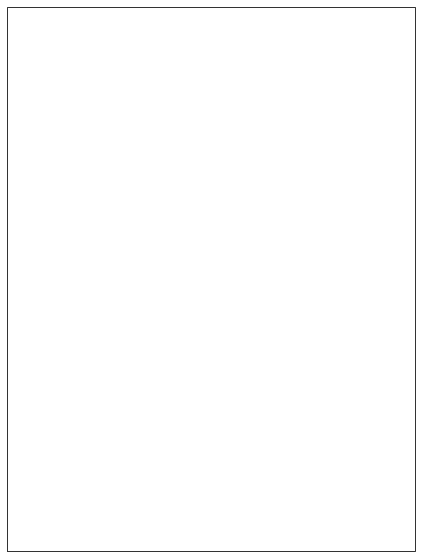

In [48]:
# Solve network and plot network insights
network.lopf(solver_name="gurobi", 
             formulation ="kirchhoff")
print_lopf_insights(network)


# print line loadings 
series_loading  = ((network.lines_t.p0.abs().mean().sort_index() / 
                    (network.lines.s_nom_opt*network.lines.s_max_pu)
                    .sort_index()).fillna(0.))


fig,ax = plt.subplots(figsize = (10,10),subplot_kw = {"projection": ccrs.PlateCarree()})

network.plot(ax=ax,
       bus_colors ="gray",
       branch_components = ["Line"],
       line_widths = network.lines.s_nom_opt/3e3,
       line_colors = series_loading,
       line_cmap=plt.cm.viridis,
       color_geomap = True,
       bus_sizes = 0,
       geomap = False)

ax.axis("on")



In [64]:
#### Create separate small model with additional pumped hydro storage units

# Build another grid with hydro storages
network_phes = network.copy()
add_storage_units(network_phes)

display(network_phes.storage_units)
display(network_phes.stores)
display(network_phes.buses)


attribute,bus,control,type,p_nom,p_nom_extendable,p_nom_min,p_nom_max,p_min_pu,p_max_pu,p_set,...,capital_cost,state_of_charge_initial,state_of_charge_set,cyclic_state_of_charge,max_hours,efficiency_store,efficiency_dispatch,standing_loss,inflow,p_nom_opt
PHES_1,bus_4_se,PQ,,150.0,True,0.0,inf,-1.0,1.0,0.0,...,0.0,0.0,NaN,False,1000.0,0.86,0.89,0.01,0.02,0.0


attribute,bus,type,e_nom,e_nom_extendable,e_nom_min,e_nom_max,e_min_pu,e_max_pu,e_initial,e_cyclic,p_set,q_set,sign,marginal_cost,capital_cost,standing_loss,e_nom_opt
name,,,,,,,,,,,,,,,,,


,v_nom,control,x,y,type,carrier,v_mag_pu_set,v_mag_pu_min,v_mag_pu_max,sub_network,generator
bus_1_nw,220.0,Slack,8.0,52.0,,AC,1.0,0.0,inf,0,coal_1
bus_2_ne,220.0,PQ,11.0,52.0,,AC,1.0,0.0,inf,0,NaN
bus_3_sw,220.0,PQ,8.0,48.0,,AC,1.0,0.0,inf,0,NaN
bus_4_se,220.0,PQ,11.0,48.0,,AC,1.0,0.0,inf,0,NaN


INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
INFO:pypsa.opf:Solving model using gurobi


DatetimeIndex(['2020-01-01 00:00:00', '2020-01-01 01:00:00',
               '2020-01-01 02:00:00', '2020-01-01 03:00:00',
               '2020-01-01 04:00:00', '2020-01-01 05:00:00',
               '2020-01-01 06:00:00', '2020-01-01 07:00:00',
               '2020-01-01 08:00:00', '2020-01-01 09:00:00',
               ...
               '2020-12-30 14:00:00', '2020-12-30 15:00:00',
               '2020-12-30 16:00:00', '2020-12-30 17:00:00',
               '2020-12-30 18:00:00', '2020-12-30 19:00:00',
               '2020-12-30 20:00:00', '2020-12-30 21:00:00',
               '2020-12-30 22:00:00', '2020-12-30 23:00:00'],
              dtype='datetime64[ns]', length=8760, freq=None)


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x140164_copy
  Lower bound: 184248889.69904867
  Upper bound: 184248889.69904867
  Number of objectives: 1
  Number of constraints: 183961
  Number of variables: 140164
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 140164
  Number of nonzeros: 411720
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termina

(7.685, 11.315000000000001, 47.58, 52.42)

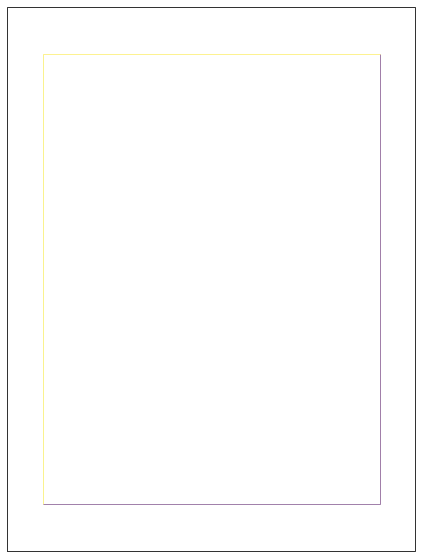

In [65]:
# Solve network_phes and plot network_phes insights
network_phes.lopf(solver_name="gurobi", 
             formulation ="kirchhoff", 
             extra_functionality = my_f)
print_lopf_insights(network_phes)

# print line loadings 
series_loading  = ((network_phes.lines_t.p0.abs().mean().sort_index() / 
                    (network_phes.lines.s_nom_opt*network_phes.lines.s_max_pu)
                    .sort_index()).fillna(0.))

fig,ax = plt.subplots(figsize = (10,10),subplot_kw = {"projection": ccrs.PlateCarree()})

network_phes.plot(ax=ax,
       bus_colors ="gray",
       branch_components = ["Line"],
       line_widths = network_phes.lines.s_nom_opt/3e3,
       line_colors = series_loading,
       line_cmap=plt.cm.viridis,
       color_geomap = True,
       bus_sizes = 0,
       geomap = False)

ax.axis("on")

In [69]:
#### Create separate small model with additional pumped hydro storage units

# Build another grid with hydro storages
network_bat = network_phes.copy()
add_BESS(network_bat)

display(network_bat.storage_units)
display(network_bat.links)
display(network_bat.stores)
display(network_bat.buses)

attribute,bus,control,type,p_nom,p_nom_extendable,p_nom_min,p_nom_max,p_min_pu,p_max_pu,p_set,...,capital_cost,state_of_charge_initial,state_of_charge_set,cyclic_state_of_charge,max_hours,efficiency_store,efficiency_dispatch,standing_loss,inflow,p_nom_opt
PHES_1,bus_4_se,PQ,,150.0,True,0.0,inf,-1.0,1.0,0.0,...,0.0,0.0,NaN,False,1000.0,0.86,0.89,0.01,0.02,256.570297


attribute,bus0,bus1,type,efficiency,p_nom,p_nom_extendable,p_nom_min,p_nom_max,p_set,p_min_pu,p_max_pu,capital_cost,marginal_cost,length,terrain_factor,p_nom_opt
Battery_1_dCH,bus_1_nw_BESS,bus_1_nw,,0.96,150.0,True,0.0,inf,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
Battery_1_CH,bus_1_nw,bus_1_nw_BESS,,0.96,150.0,True,0.0,inf,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
Battery_2_dCH,bus_2_ne_BESS,bus_2_ne,,0.96,150.0,True,0.0,inf,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
Battery_2_CH,bus_2_ne,bus_2_ne_BESS,,0.96,150.0,True,0.0,inf,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
Battery_3_dCH,bus_3_sw_BESS,bus_3_sw,,0.96,150.0,True,0.0,inf,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
Battery_3_CH,bus_3_sw,bus_3_sw_BESS,,0.96,150.0,True,0.0,inf,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
Battery_4_dCH,bus_4_se_BESS,bus_4_se,,0.96,150.0,True,0.0,inf,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
Battery_4_CH,bus_4_se,bus_4_se_BESS,,0.96,150.0,True,0.0,inf,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


attribute,bus,type,e_nom,e_nom_extendable,e_nom_min,e_nom_max,e_min_pu,e_max_pu,e_initial,e_cyclic,p_set,q_set,sign,marginal_cost,capital_cost,standing_loss,e_nom_opt
BESS_0,bus_1_nw_BESS,,200.0,False,0.0,inf,0.0,1.0,0.5,True,100.0,0.05,1.0,0.0,0.0,0.0,0.0
BESS_1,bus_2_ne_BESS,,200.0,False,0.0,inf,0.0,1.0,0.5,True,100.0,0.05,1.0,0.0,0.0,0.0,0.0
BESS_2,bus_3_sw_BESS,,200.0,False,0.0,inf,0.0,1.0,0.5,True,100.0,0.05,1.0,0.0,0.0,0.0,0.0
BESS_3,bus_4_se_BESS,,200.0,False,0.0,inf,0.0,1.0,0.5,True,100.0,0.05,1.0,0.0,0.0,0.0,0.0


,v_nom,control,x,y,type,carrier,v_mag_pu_set,v_mag_pu_min,v_mag_pu_max,sub_network,generator
bus_1_nw,220.0,Slack,8.0,52.0,,AC,1.0,0.0,inf,0,coal_1
bus_2_ne,220.0,PQ,11.0,52.0,,AC,1.0,0.0,inf,0,NaN
bus_3_sw,220.0,PQ,8.0,48.0,,AC,1.0,0.0,inf,0,NaN
bus_4_se,220.0,PQ,11.0,48.0,,AC,1.0,0.0,inf,0,NaN
bus_1_nw_BESS,1.0,PQ,8.0,52.0,,battery,1.0,0.0,inf,,NaN
bus_2_ne_BESS,1.0,PQ,11.0,52.0,,battery,1.0,0.0,inf,,NaN
bus_3_sw_BESS,1.0,PQ,8.0,48.0,,battery,1.0,0.0,inf,,NaN
bus_4_se_BESS,1.0,PQ,11.0,48.0,,battery,1.0,0.0,inf,,NaN


INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
INFO:pypsa.opf:Solving model using gurobi


DatetimeIndex(['2020-01-01 00:00:00', '2020-01-01 01:00:00',
               '2020-01-01 02:00:00', '2020-01-01 03:00:00',
               '2020-01-01 04:00:00', '2020-01-01 05:00:00',
               '2020-01-01 06:00:00', '2020-01-01 07:00:00',
               '2020-01-01 08:00:00', '2020-01-01 09:00:00',
               ...
               '2020-12-30 14:00:00', '2020-12-30 15:00:00',
               '2020-12-30 16:00:00', '2020-12-30 17:00:00',
               '2020-12-30 18:00:00', '2020-12-30 19:00:00',
               '2020-12-30 20:00:00', '2020-12-30 21:00:00',
               '2020-12-30 22:00:00', '2020-12-30 23:00:00'],
              dtype='datetime64[ns]', length=8760, freq=None)


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x280332_copy
  Lower bound: 180647809.92399108
  Upper bound: 180647809.92399108
  Number of objectives: 1
  Number of constraints: 394201
  Number of variables: 280332
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 280332
  Number of nonzeros: 902280
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termina

(7.685, 11.315000000000001, 47.58, 52.42)

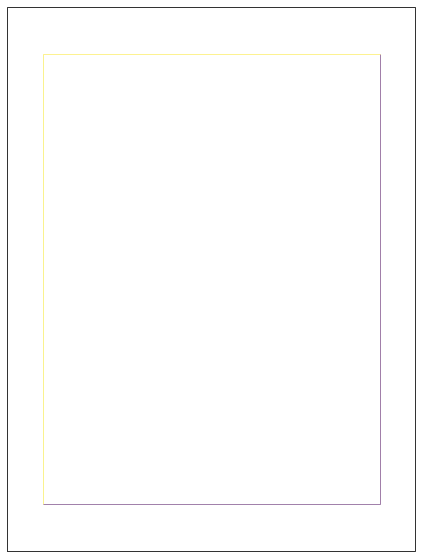

In [70]:
# Solve network_bat and plot network_bat insights
network_bat.lopf(solver_name="gurobi", 
             formulation ="kirchhoff", 
             extra_functionality = my_f)
print_lopf_insights(network_bat)

# print line loadings 
series_loading  = ((network_bat.lines_t.p0.abs().mean().sort_index() / 
                    (network_bat.lines.s_nom_opt*network_bat.lines.s_max_pu)
                    .sort_index()).fillna(0.))

fig,ax = plt.subplots(figsize = (10,10),subplot_kw = {"projection": ccrs.PlateCarree()})

network_bat.plot(ax=ax,
       bus_colors ="gray",
       branch_components = ["Line"],
       line_widths = network_bat.lines.s_nom_opt/3e3,
       line_colors = series_loading,
       line_cmap=plt.cm.viridis,
       color_geomap = True,
       bus_sizes = 0,
       geomap = False)

ax.axis("on")

In [40]:
    
def add_time_series():
    '''
    Adds all necessary time series to the model:
    - time series for loads
    - time series for wind generation
    - time series for solar generation
    '''
    # load time series
    network.loads_t.p_set = pd.DataFrame(index = network.snapshots, 
                                         columns = network.loads.index,
                                         data = 1000*np.random.rand(len(network.snapshots), len(network.loads)))
    # wind power time series
    wind_generators = network.generators[network.generators.carrier == "wind"]
    network.generators_t.p_max_pu = network.generators_t.p_max_pu.reindex(columns=wind_generators.index)
    network.generators_t.p_max_pu.loc[:,wind_generators.index] = pd.DataFrame(index = network.snapshots,
                                                                          columns = wind_generators.index,
                                                                          data = np.random.rand(len(network.snapshots), len(wind_generators)))
    # solar generators 
    solar_generators = network.generators[network.generators.carrier == "solar"]
    network.generators_t.p_max_pu.loc[:,solar_generators.index] = pd.DataFrame(index = network.snapshots,
                                                                          columns = solar_generators.index,
                                                                          data = np.random.rand(len(network.snapshots), len(solar_generators)))


'''
Creates time series for load, wind generation and solar generation by scaling the scalar nominal power 
with relative generation time series for germany (relative to mean generation of each technology)
'''

# Import load and generation data for germany
df_ger = pd.read_csv(r"C:\Users\Willem\pypsa-eur\data\Redispatch\opsd-time_series-2020-10-06/time_series_60min_singleindex.csv")
cols_ger = list(df_ger.loc[:,"DE_load_actual_entsoe_transparency":'DE_transnetbw_wind_onshore_generation_actual'])
cols_ger.append("cet_cest_timestamp")
cols_ger = [cols_ger[-1]] + cols_ger[:-1]
df_ger = df_ger.loc[:,cols_ger]

# change index to datetime object
df_ger[["Date","Time"]] = df_ger["cet_cest_timestamp"].str.split(pat = "T", expand = True)
df_ger[["Time","xxxx"]] = df_ger["Time"].str.split(pat = "+", expand = True)
df_ger = df_ger.drop(["xxxx","cet_cest_timestamp"],axis = 1)
df_ger["name"] = pd.to_datetime(df_ger['Date'] + ' ' + df_ger['Time'])
df_ger = df_ger.drop(["Date","Time"], axis = 1).set_index("name", drop = True)
df_ger = df_ger.loc["2019-01-01 00:00:00":"2019-12-31 23:00:00", :]
#df_ger = df_ger[~df_ger.index.duplicated(keep='first')]
df_ger.reset_index(inplace = True, drop = True)
display(df_ger)

# Generate relative columns to get the load profile
s_loads = df_ger["DE_load_actual_entsoe_transparency"].divide(df_ger["DE_load_actual_entsoe_transparency"].mean())
s_wind  = df_ger["DE_wind_generation_actual"].divide(df_ger["DE_wind_generation_actual"].mean())
s_solar = df_ger["DE_solar_generation_actual"].divide(df_ger["DE_solar_generation_actual"].mean())

#### Time series to dicts

# Create empty dicts
dict_loads = {}
dict_wind = {}
dict_solar = {}

# load time series
for load in network.loads.index:
    dict_loads[load] = s_loads * network.loads.p_set[load] 
# wind time series
wind_generators = network.generators[network.generators.carrier == "wind"]
for wind in wind_generators.index:
    dict_wind[wind] = s_wind
# Solar time series
solar_generators = network.generators[network.generators.carrier == "solar"]
for solar in solar_generators.index:
    dict_solar[solar] = s_solar
    
#### Dicts to dataframes

df_loads = pd.DataFrame.from_dict(dict_loads, orient = "columns")
df_wind = pd.DataFrame.from_dict(dict_wind, orient = "columns")
df_solar = pd.DataFrame.from_dict(dict_solar, orient = "columns")

# load time series
network.loads_t.p_set = pd.DataFrame(index = network.snapshots, 
                                     columns = network.loads.index,
                                     data = df_loads.to_numpy(copy = True))
# Wind time series
network.generators_t.p_max_pu = network.generators_t.p_max_pu.reindex(columns=wind_generators.index)
network.generators_t.p_max_pu.loc[:,wind_generators.index] = pd.DataFrame(index = network.snapshots,
                                                                          columns = wind_generators.index,
                                                                          data = df_wind.to_numpy(copy= True))
# Solar time series
network.generators_t.p_max_pu.loc[:,solar_generators.index] = pd.DataFrame(index = network.snapshots,
                                                                          columns = solar_generators.index,
                                                                          data = df_solar.to_numpy(copy= True))


,DE_load_actual_entsoe_transparency,DE_load_forecast_entsoe_transparency,DE_solar_capacity,DE_solar_generation_actual,DE_solar_profile,DE_wind_capacity,DE_wind_generation_actual,DE_wind_profile,DE_wind_offshore_capacity,DE_wind_offshore_generation_actual,DE_wind_offshore_profile,DE_wind_onshore_capacity,DE_wind_onshore_generation_actual,DE_wind_onshore_profile,DE_50hertz_load_actual_entsoe_transparency,DE_50hertz_load_forecast_entsoe_transparency,DE_50hertz_solar_generation_actual,DE_50hertz_wind_generation_actual,DE_50hertz_wind_offshore_generation_actual,DE_50hertz_wind_onshore_generation_actual,DE_LU_load_actual_entsoe_transparency,DE_LU_load_forecast_entsoe_transparency,DE_LU_price_day_ahead,DE_LU_solar_generation_actual,DE_LU_wind_generation_actual,DE_LU_wind_offshore_generation_actual,DE_LU_wind_onshore_generation_actual,DE_amprion_load_actual_entsoe_transparency,DE_amprion_load_forecast_entsoe_transparency,DE_amprion_solar_generation_actual,DE_amprion_wind_onshore_generation_actual,DE_tennet_load_actual_entsoe_transparency,DE_tennet_load_forecast_entsoe_transparency,DE_tennet_solar_generation_actual,DE_tennet_wind_generation_actual,DE_tennet_wind_offshore_generation_actual,DE_tennet_wind_onshore_generation_actual,DE_transnetbw_load_actual_entsoe_transparency,DE_transnetbw_load_forecast_entsoe_transparency,DE_transnetbw_solar_generation_actual,DE_transnetbw_wind_onshore_generation_actual
0,42976.0,43213.0,47480.0,0.0,0.0,48974.0,23132.0,0.4723,5051.0,3136.0,0.6210,43923.0,19995.0,0.4552,8880.0,6504.0,0.0,8847.0,1020.0,7827.0,43490.0,43628.0,28.32,0.0,23132.0,3136.0,19995.0,15331.0,17560.0,0.0,2408.0,13724.0,13557.0,0.0,11783.0,2116.0,9667.0,5041.0,5593.0,0.0,94.0
1,41562.0,41275.0,47480.0,0.0,0.0,48974.0,24905.0,0.5085,5051.0,2868.0,0.5678,43923.0,22036.0,0.5017,8604.0,6161.0,0.0,9671.0,1015.0,8656.0,41902.0,41662.0,10.07,0.0,24905.0,2868.0,22036.0,14872.0,16896.0,0.0,2979.0,13222.0,12943.0,0.0,12150.0,1853.0,10297.0,4864.0,5275.0,0.0,105.0
2,40100.0,40188.0,47480.0,0.0,0.0,48974.0,25208.0,0.5147,5051.0,2460.0,0.4870,43923.0,22748.0,0.5179,8205.0,6035.0,0.0,9966.0,660.0,9307.0,40291.0,40553.0,-4.08,0.0,25208.0,2460.0,22748.0,14823.0,16632.0,0.0,3123.0,12464.0,12611.0,0.0,12015.0,1800.0,10214.0,4607.0,4910.0,0.0,103.0
3,38883.0,39909.0,47480.0,0.0,0.0,48974.0,26568.0,0.5425,5051.0,2698.0,0.5341,43923.0,23870.0,0.5435,7609.0,6057.0,0.0,10316.0,615.0,9701.0,39274.0,40261.0,-9.91,0.0,26568.0,2698.0,23870.0,14640.0,16552.0,0.0,3524.0,12108.0,12521.0,0.0,12578.0,2082.0,10496.0,4526.0,4778.0,0.0,149.0
4,38806.0,40258.0,47480.0,0.0,0.0,48974.0,28500.0,0.5819,5051.0,2578.0,0.5105,43923.0,25922.0,0.5902,7564.0,6120.0,0.0,10910.0,494.0,10416.0,39191.0,40603.0,-7.41,0.0,28500.0,2578.0,25922.0,14678.0,16667.0,0.0,4096.0,11963.0,12677.0,0.0,13298.0,2084.0,11214.0,4601.0,4794.0,0.0,196.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,50151.0,56841.0,NaN,0.0,NaN,NaN,9702.0,NaN,NaN,1251.0,NaN,NaN,8451.0,NaN,10406.0,12344.0,0.0,6138.0,768.0,5370.0,50612.0,57642.0,46.00,0.0,9702.0,1251.0,8451.0,17977.0,22350.0,0.0,1013.0,15763.0,16467.0,0.0,2473.0,483.0,1990.0,6005.0,5680.0,0.0,79.0
8756,47493.0,54131.0,NaN,0.0,NaN,NaN,8875.0,NaN,NaN,873.0,NaN,NaN,8002.0,NaN,10027.0,11519.0,0.0,5910.0,599.0,5310.0,47928.0,54874.0,42.20,0.0,8875.0,873.0,8002.0,17037.0,21190.0,0.0,1076.0,14753.0,15838.0,0.0,1764.0,274.0,1490.0,5676.0,5584.0,0.0,126.0
8757,45842.0,51764.0,NaN,0.0,NaN,NaN,7652.0,NaN,NaN,704.0,NaN,NaN,6948.0,NaN,9562.0,10705.0,0.0,5175.0,553.0,4622.0,46235.0,52437.0,39.74,0.0,7652.0,704.0,6948.0,16754.0,20351.0,0.0,984.0,14018.0,15145.0,0.0,1384.0,151.0,1233.0,5507.0,5564.0,0.0,109.0
8758,45501.0,50569.0,NaN,0.0,NaN,NaN,7283.0,NaN,NaN,575.0,NaN,NaN,6708.0,NaN,9412.0,10300.0,0.0,4726.0,518.0,4208.0,45871.0,51283.0,38.88,0.0,7283.0,575.0,6708.0,16495.0,19473.0,0.0,1182.0,14064.0,15275.0,0.0,1223.0,57.0,1166.0,5530.0,5522.0

,load_1_ne,load_2_sw,load_3_se
0,383.780544,1151.341631,767.561087
1,371.153364,1113.460091,742.306727
2,358.097538,1074.292615,716.195076
3,347.229591,1041.688772,694.459181
4,346.541972,1039.625915,693.083944
...,...,...,...
8755,447.854106,1343.562317,895.708211
8756,424.117865,1272.353595,848.235730
8757,409.374248,1228.122744,818.748496
8758,406.329079,1218.987238,812.658159


,Wind_1
0,1.636560
1,1.761998
2,1.783435
3,1.879653
4,2.016340
...,...
8755,0.686404
8756,0.627895
8757,0.541370
8758,0.515263


,PV_1
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0
...,...
8755,0.0
8756,0.0
8757,0.0
8758,0.0
